# Exrcise 22: Galaxy vs quasar with deep learning

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do you best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard) (but don't start learning about it now, it takes a while to get it up and running).

---

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import corner

from sklearn.base import  clone

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score

from astroML.utils import pickle_results

import pandas as pd
from IPython.display import display

%config InlineBackend.figure_format='retina'

## Prepare Data

In [2]:
file = '../solutions/galaxyquasar.csv'
data_csv = np.genfromtxt(file, delimiter=',', usecols=(0,1,2,3,4,5), dtype = str)
print(data_csv)

[['u' 'g' 'r' 'i' 'z' 'class']
 ['18.97213' '18.53676' '18.5828' '18.34936' '18.29215' 'QSO']
 ['19.24592' '17.47646' '16.47817' '16.04472' '15.68851' 'GALAXY']
 ...
 ['18.62718' '17.30876' '16.87371' '16.62399' '16.42296' 'GALAXY']
 ['19.5514' '18.27711' '17.62101' '17.21947' '17.03347' 'GALAXY']
 ['18.80772' '17.75751' '17.405' '17.2165' '17.12295' 'GALAXY']]


In [3]:
lab = np.char.replace(data_csv[1:,5], 'GALAXY', '0')
lab = np.char.replace(lab, 'QSO', '1').astype(int)

ug = data_csv[1:,0].astype(float) - data_csv[1:,1].astype(float)
gr = data_csv[1:,1].astype(float) - data_csv[1:,2].astype(float)
ri = data_csv[1:,2].astype(float) - data_csv[1:,3].astype(float)
iz = data_csv[1:,3].astype(float) - data_csv[1:,4].astype(float)

data = np.column_stack((ug,gr,ri,iz))

galaxies = data[: , :4][lab==1].astype(float)
quasars = data[: , :4][lab==0].astype(float)

names = ['u-g', 'g-r', 'r-i', 'i-z']

First we check the distribution of the features

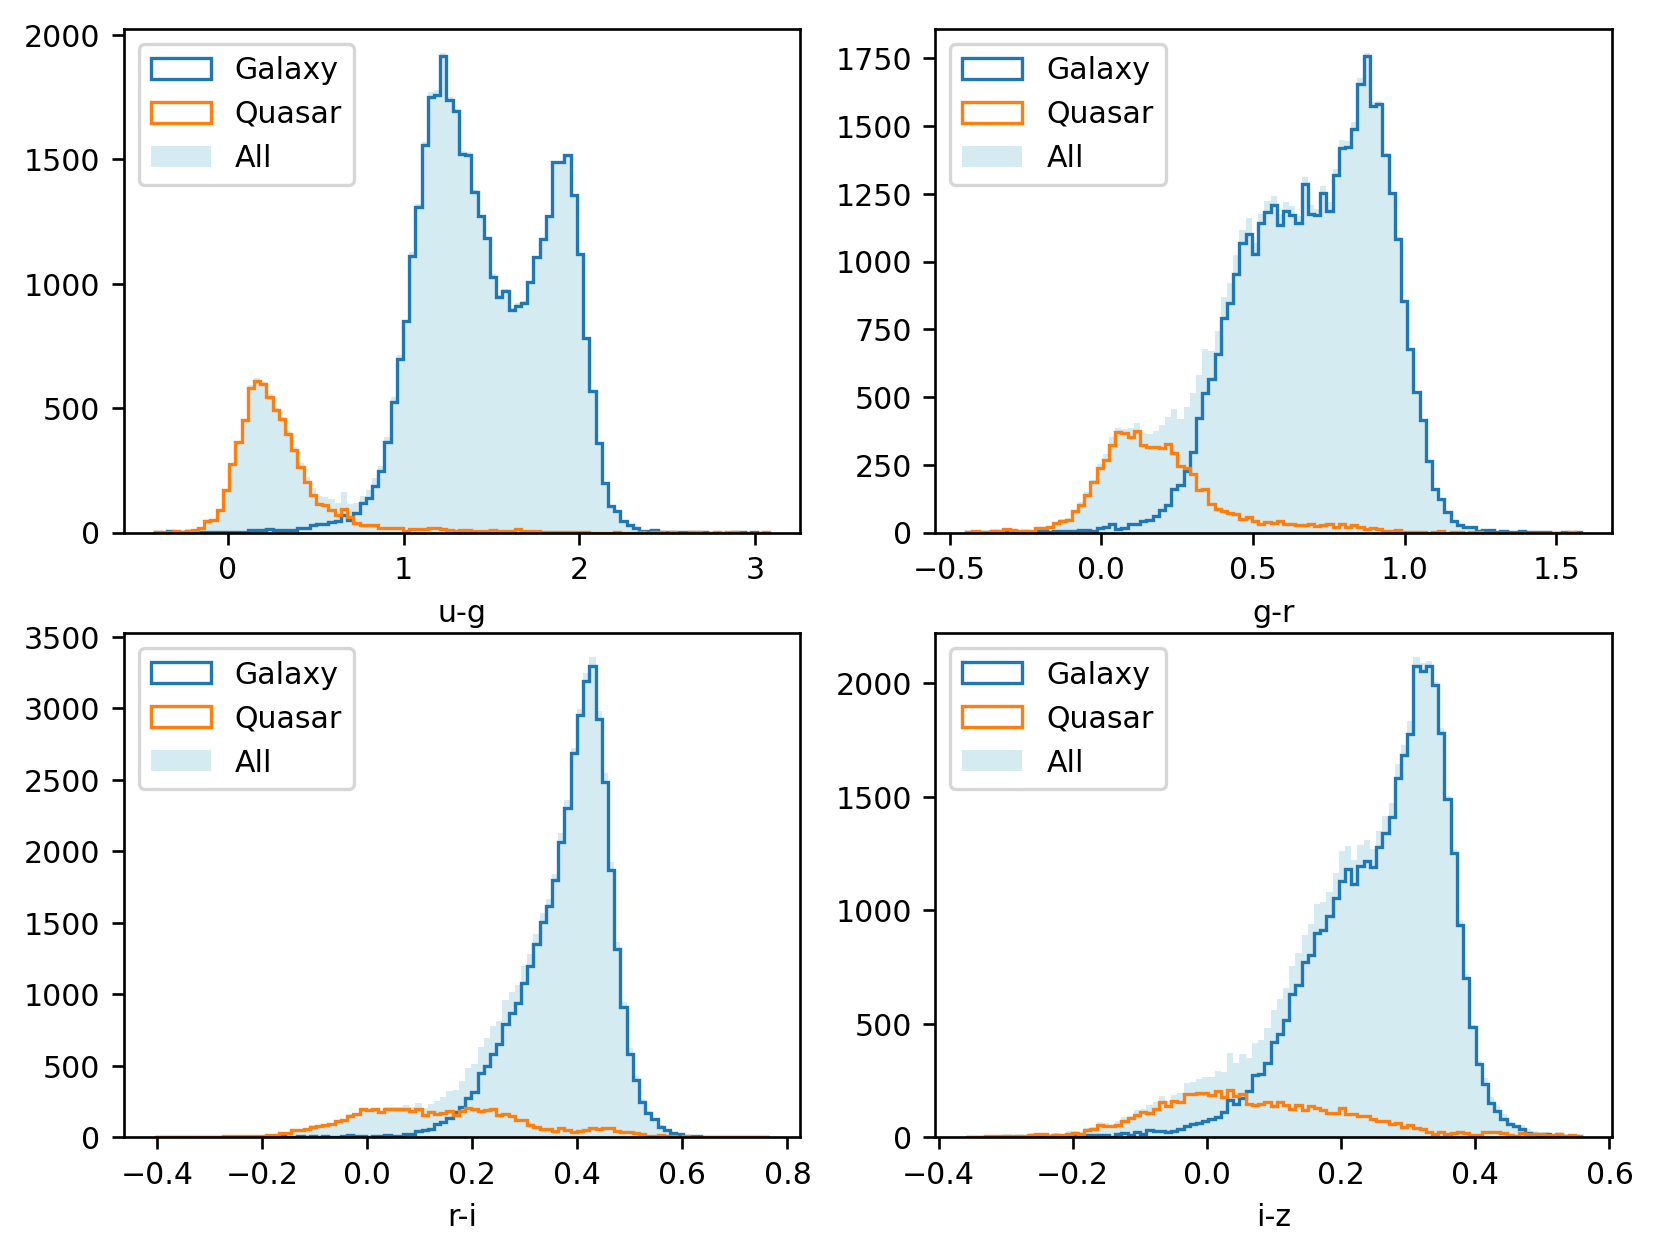

In [4]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,6), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig, axs = plt.subplots(2,2)

# bins = 'auto'
quant_list = [(0.0005, 0.9995),(0.001, 0.9995),(0.001, 0.999),(0.003, 0.997)] # Got boundaries by eye
bounds = []

for ax,color, name, quant in zip(axs.flatten() ,data[:,:4].T,names, quant_list):
    
    min, max = np.quantile(color, quant)
    bounds.append([min,max])
    bins = np.linspace(min, max, 100)   
    gala = color[lab==0]
    quas = color[lab==1]
    ax.hist(gala, bins=bins, histtype = 'step', label = 'Galaxy', lw=1)
    ax.hist(quas, bins=bins, histtype = 'step', label = 'Quasar', lw=1)
    ax.hist(color, bins=bins, label = 'All', color='lightblue', alpha=0.5,)
    ax.legend()
    ax.set_xlabel(name)
    # ax.set_yscale('log')
    
plt.tight_layout;

From color distributions it seems that u-g is by far the most informative feature as it shows a clear bimodality differentiating galaxies and quasars. For the other colors, quasars only create a small bump in the total distribution.

In the above histograms we choose x axes boundaries using data quantiles to exclude outliers and look at bulk distributions for each color. 

Checking histograms including all data we see that there are some outliers: we trim them from the data sample.


In [5]:
# Remove outliers
bounds = np.array(bounds)
data_t = data.T

# mask on transposed data matrix
mask1 = np.array([np.logical_and(bounds[i,0] < data.T[i], data.T[i] < bounds[i,1]) for i in [0,1,2,3]])
mask2 = np.all(mask1,axis=0)

data_clean = data[mask2,:]
lab_clean = lab[mask2]

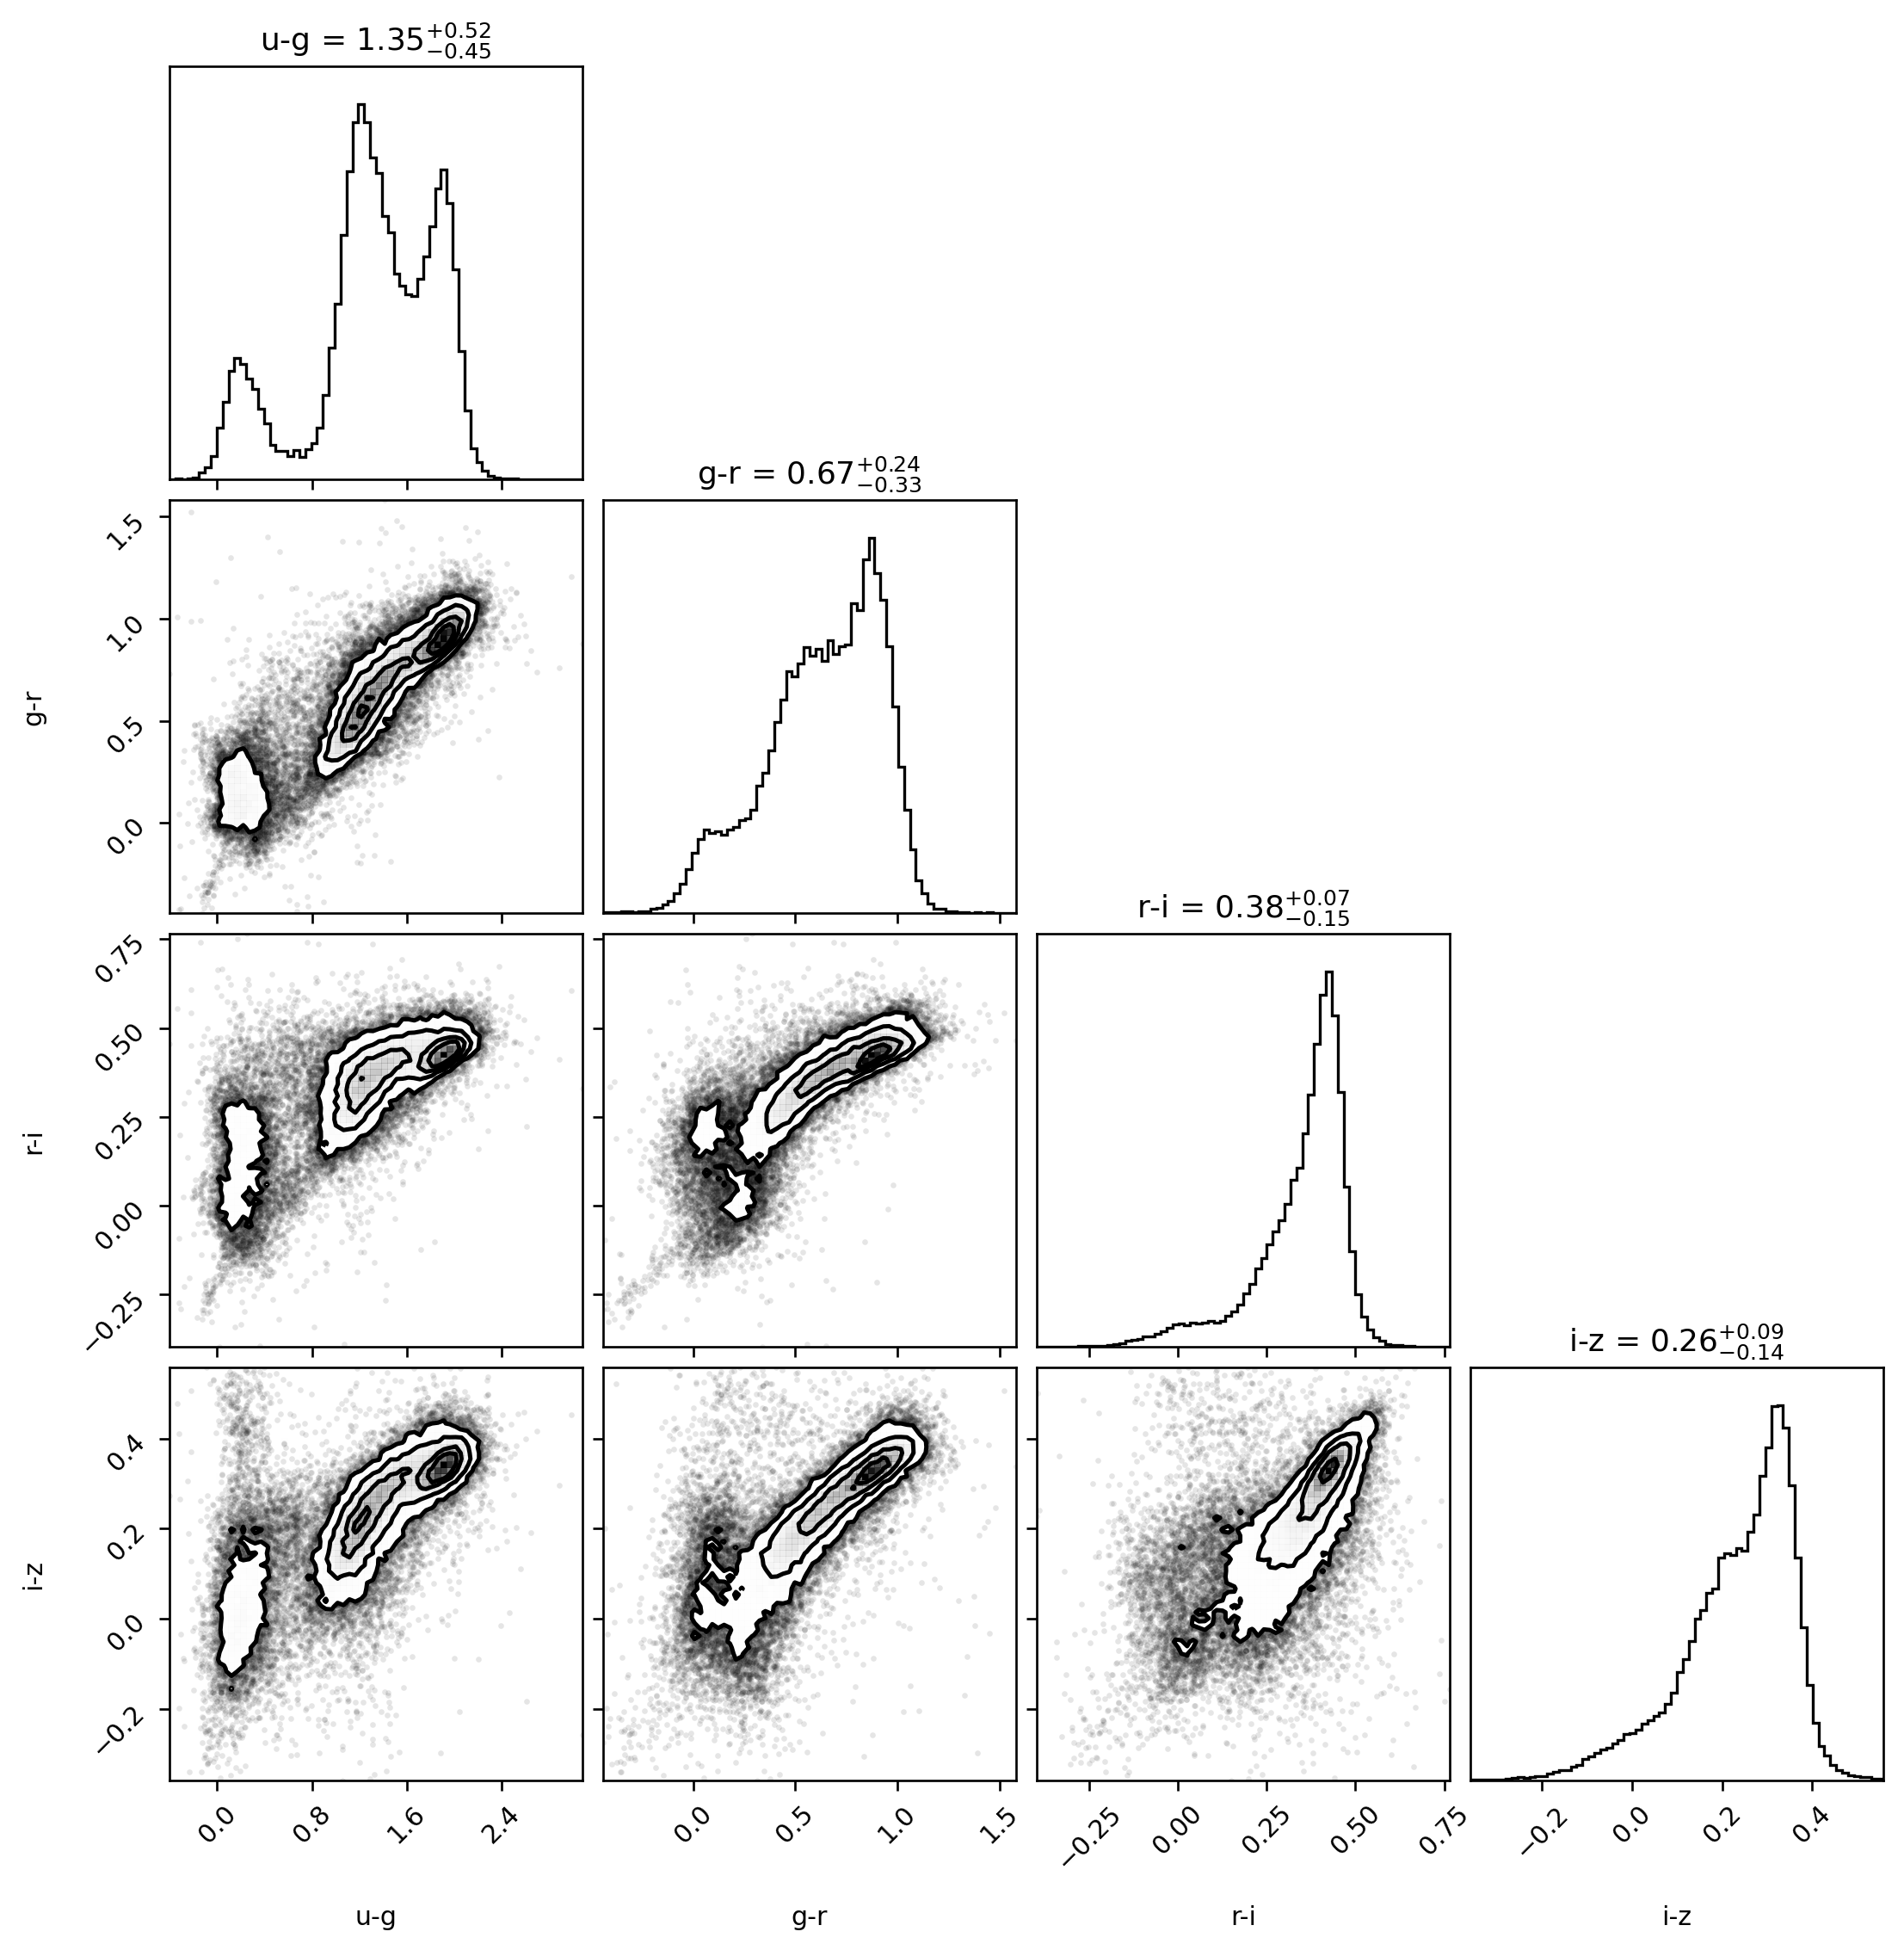

In [6]:
corner.corner(data_clean, labels = names, bins=70, show_titles=True);

In [7]:
# Train and test sets
X = data_clean
y = lab_clean

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=0)

# Scaling data after split to avoid information leakage from test 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neural Networks

In [62]:
# USEFUL FUNCTIONS
###################################################

def run_classifier(clf, **kwargs):
    '''
    Trains and evaluates performance of a single classifier
    Use kwarg name= 'custom_name' to use custom name
    
    Input: clf(sklearn classifier object), name(str)
    Output: list of "info" containing a list of [metrics, curves], clf params, clf input name
    '''
    name = kwargs.get('name', str(clf) )

    clf.fit(X_train, y_train)
    
    y_probs = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    
    complet = recall_score(y_test, y_pred)
    contam = 1 - precision_score(y_test, y_pred)
    accur = accuracy_score(y_test, y_pred)
    
    metrics = np.array([accur, complet, contam])
    
    fpr, tpr, thresh = roc_curve(y_test, y_probs)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    
    curves = [[fpr,tpr],[precision,recall]]
    
    results = [metrics, curves]
    params = clf.get_params()
    
    info = [results, params, name]
    return  info

###################################################

def run_classifier_list (classifiers_list, **kwargs):
    '''
    Trains and evalutate performance of a list of classifiers
    Use kwarg names= ['name1','name2',..] to use custom name list for classifiers
    
    Inputs: list of classifiers, listo of names
    Output: list of "info" lists from run_classifier() function'''
    
    names = kwargs.get('names', [str(clf) for clf in classifiers_list] )
    
    info_list = []
    for clf, name in zip(classifiers_list,names):
        info_list.append(run_classifier(clf, name=name))
    return info_list

###################################################

def compare_classifiers(info_list, plot_curves = True, plot_metrics_bars = True):
    ''' 
    Compares performance of classifiers evaluated beforehand.
    
    Input: list of outputs from run_classifier()
    Output: metrics pd.DataFrame, list of params of the classifiers
    '''
    results_list = [info[0] for info in info_list]
    params_list = [info[1] for info in info_list]
    names = [info[2] for info in info_list]

    metrics_arr = np.array([results[0] for results in results_list]).T
    keys = ['name', 'accuracy', 'completeness', 'contamination']
    metrics_d = dict(zip(keys,[names, *metrics_arr]))
    
    metrics_dataframe = pd.DataFrame(metrics_d).sort_values("accuracy", ascending=False)
    display(metrics_dataframe)
    
    if plot_curves == True:
        
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(9,3), dpi=120)
        plt.rcParams.update({'font.size': 9})         
        #--------------------------------------------
        
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        for results,name  in zip(results_list,names):
            curves = results[1]
            roc = curves[0]
            prec_rec = curves[1]
            ax1.plot(roc[0],roc[1], label=name)
            ax2.plot(prec_rec[0], prec_rec[1], label=name)
            
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('true positive rate')
        ax1.set_title('ROC curves')
        ax1.legend(loc=4)
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))        
        ax1.set_xlim(0, 0.04)
        ax1.set_ylim(0.9, 1.01)
        ax2.set_xlabel('precision')
        ax2.set_ylabel('recall')
        ax2.set_title('Precision - Recall curves')
        ax2.set_xlim(0, 1.0)
        ax2.set_ylim(0.9, 1.01);
        
        
    if plot_metrics_bars == True:
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(10,5), dpi=120)
        plt.rcParams.update({'font.size': 10})
        #--------------------------------------------

        fig, axs = plt.subplots(1,3)
        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        
        
        margins = [0.001,0.01,0.001]
        x=1
        labels = ['Accuracy', 'Completeness', 'Contamination']
        width = 1  # the width of the bars
        
        for i,(ax, label) in enumerate(zip(axs.flatten(),labels)):
            j=0
            for name, metrics in zip(names, metrics_arr.T):
                rect = ax.bar(x+width*j, metrics[i], width, label=name)         
                ax.bar_label(rect, padding=3, fmt='%.4f', fontsize=8)
                j+=1
            ax.set_title(label)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(np.min(metrics_arr[i]) - margins[i], np.max(metrics_arr[i] + margins[i] )) 
        axs[0].set_ylabel('Scores')
            
            # Legend next to graph
            # ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1)) 
        
            # Put a vertical legend below current axis
        axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
            
            # Put a horizontal legend below current axis
            # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
            
        # fig.tight_layout()
            

    return metrics_dataframe, params_list

###################################################

if False:
# To do everything in one go
    def evaluate_classifiers(clf_list, names, plot_curves = True, plot_metrics_bars = True): 
        '''
        Trains and compares different classifiers.
        
        Input: List of classifiers, list of names
        Output: metrics pd.DataFrame and list of classifier params
        If plot = True (default) plots ROC and precision-recall curves
        '''
        info_list = []
        
        for clf,name in zip(clf_list,names): # Run classifiers using above funciton
            info = run_classifier(clf,name)
            info_list.append(info)
            
        metrics_dataframe, params_list = compare_classifiers(info_list, plot_curves, plot_metrics_bars)
                    
        return metrics_dataframe, params_list


In [58]:
# Define classifiers

mlp_base = MLPClassifier(
                    hidden_layer_sizes=(5,),
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate_init=0.001)

mlp_2layers = MLPClassifier(
                    hidden_layer_sizes=(5,5),
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate_init=0.001)

mlp_10neurons = MLPClassifier(
                    hidden_layer_sizes=(10,),
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate_init=0.001)

kneighbors = KNeighborsClassifier(9)


In [59]:
classifiers_list = [mlp_base, mlp_2layers, mlp_10neurons, kneighbors]
# names = ['MLP_base', 'MLP_2layers', 'MLP_10neurons', 'K-neighbors']

info_list1 = run_classifier_list(classifiers_list)

,name,accuracy,completeness,contamination
3,KNeighborsClassifier(n_neighbors=9),0.987307,0.943306,0.034146
2,"MLPClassifier(hidden_layer_sizes=(10,))",0.987240,0.940924,0.032337
1,"MLPClassifier(hidden_layer_sizes=(5, 5))",0.987173,0.938542,0.030512
0,"MLPClassifier(hidden_layer_sizes=(5,))",0.986635,0.935207,0.031096


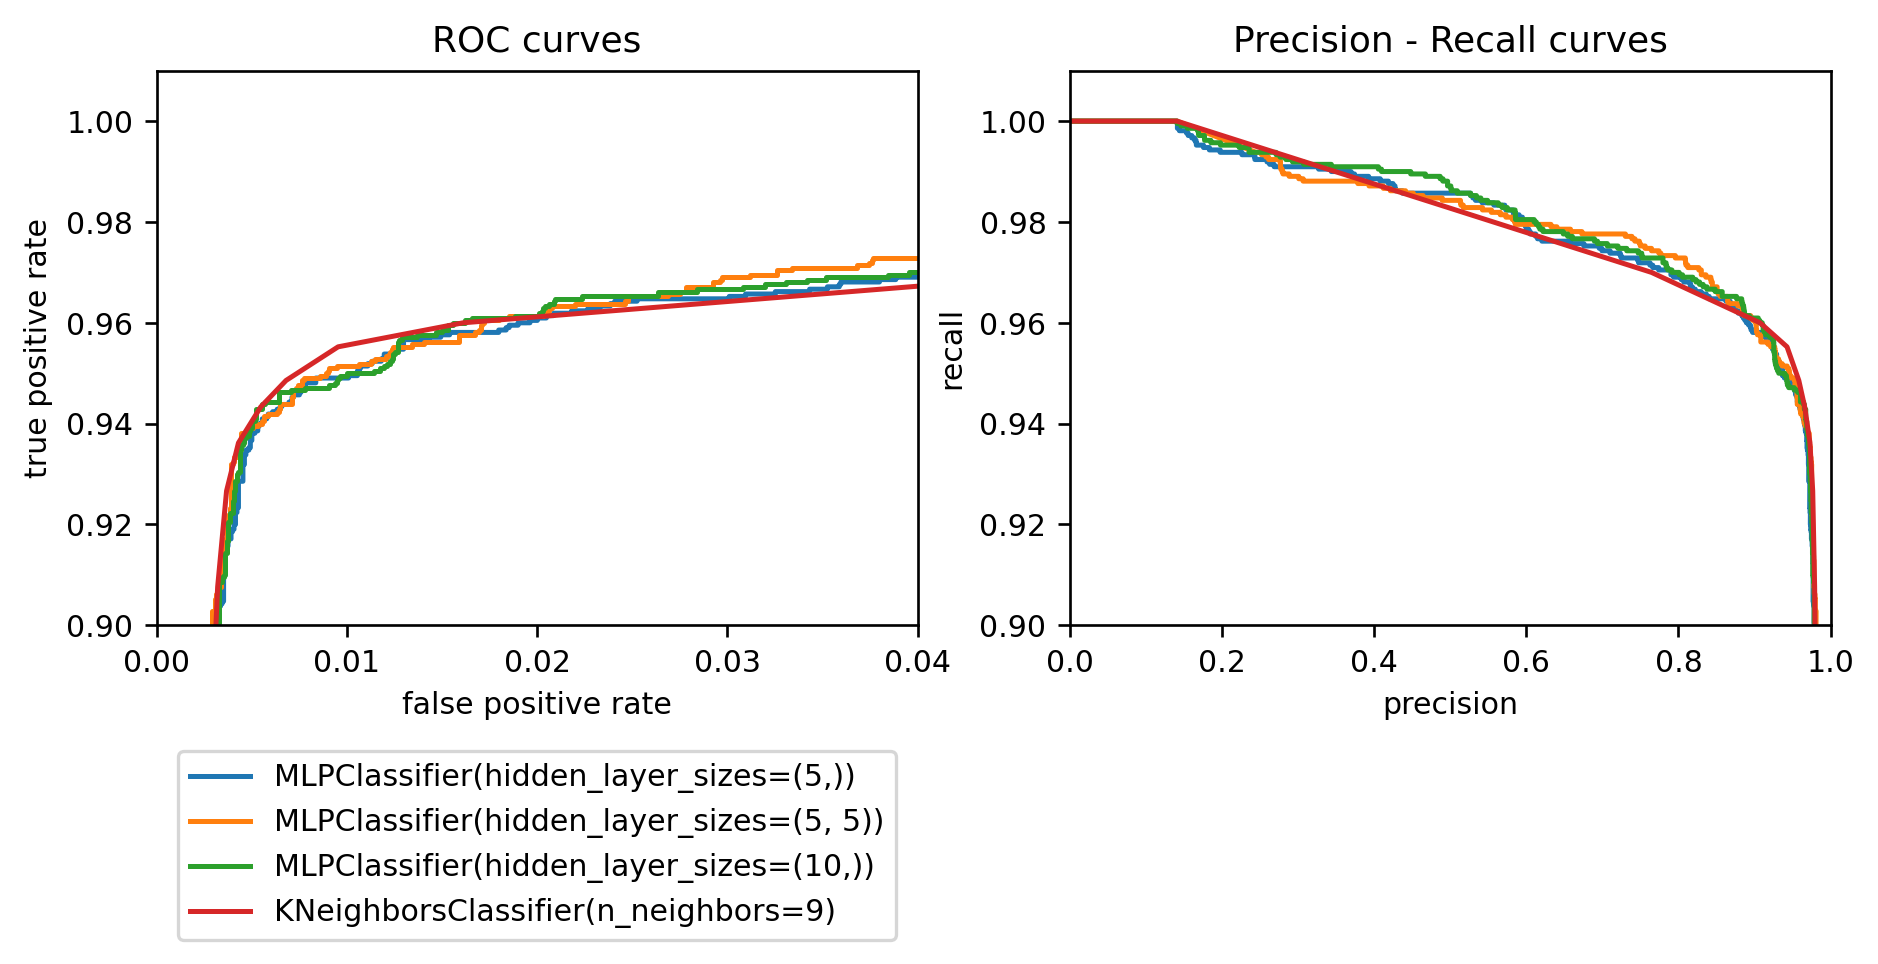

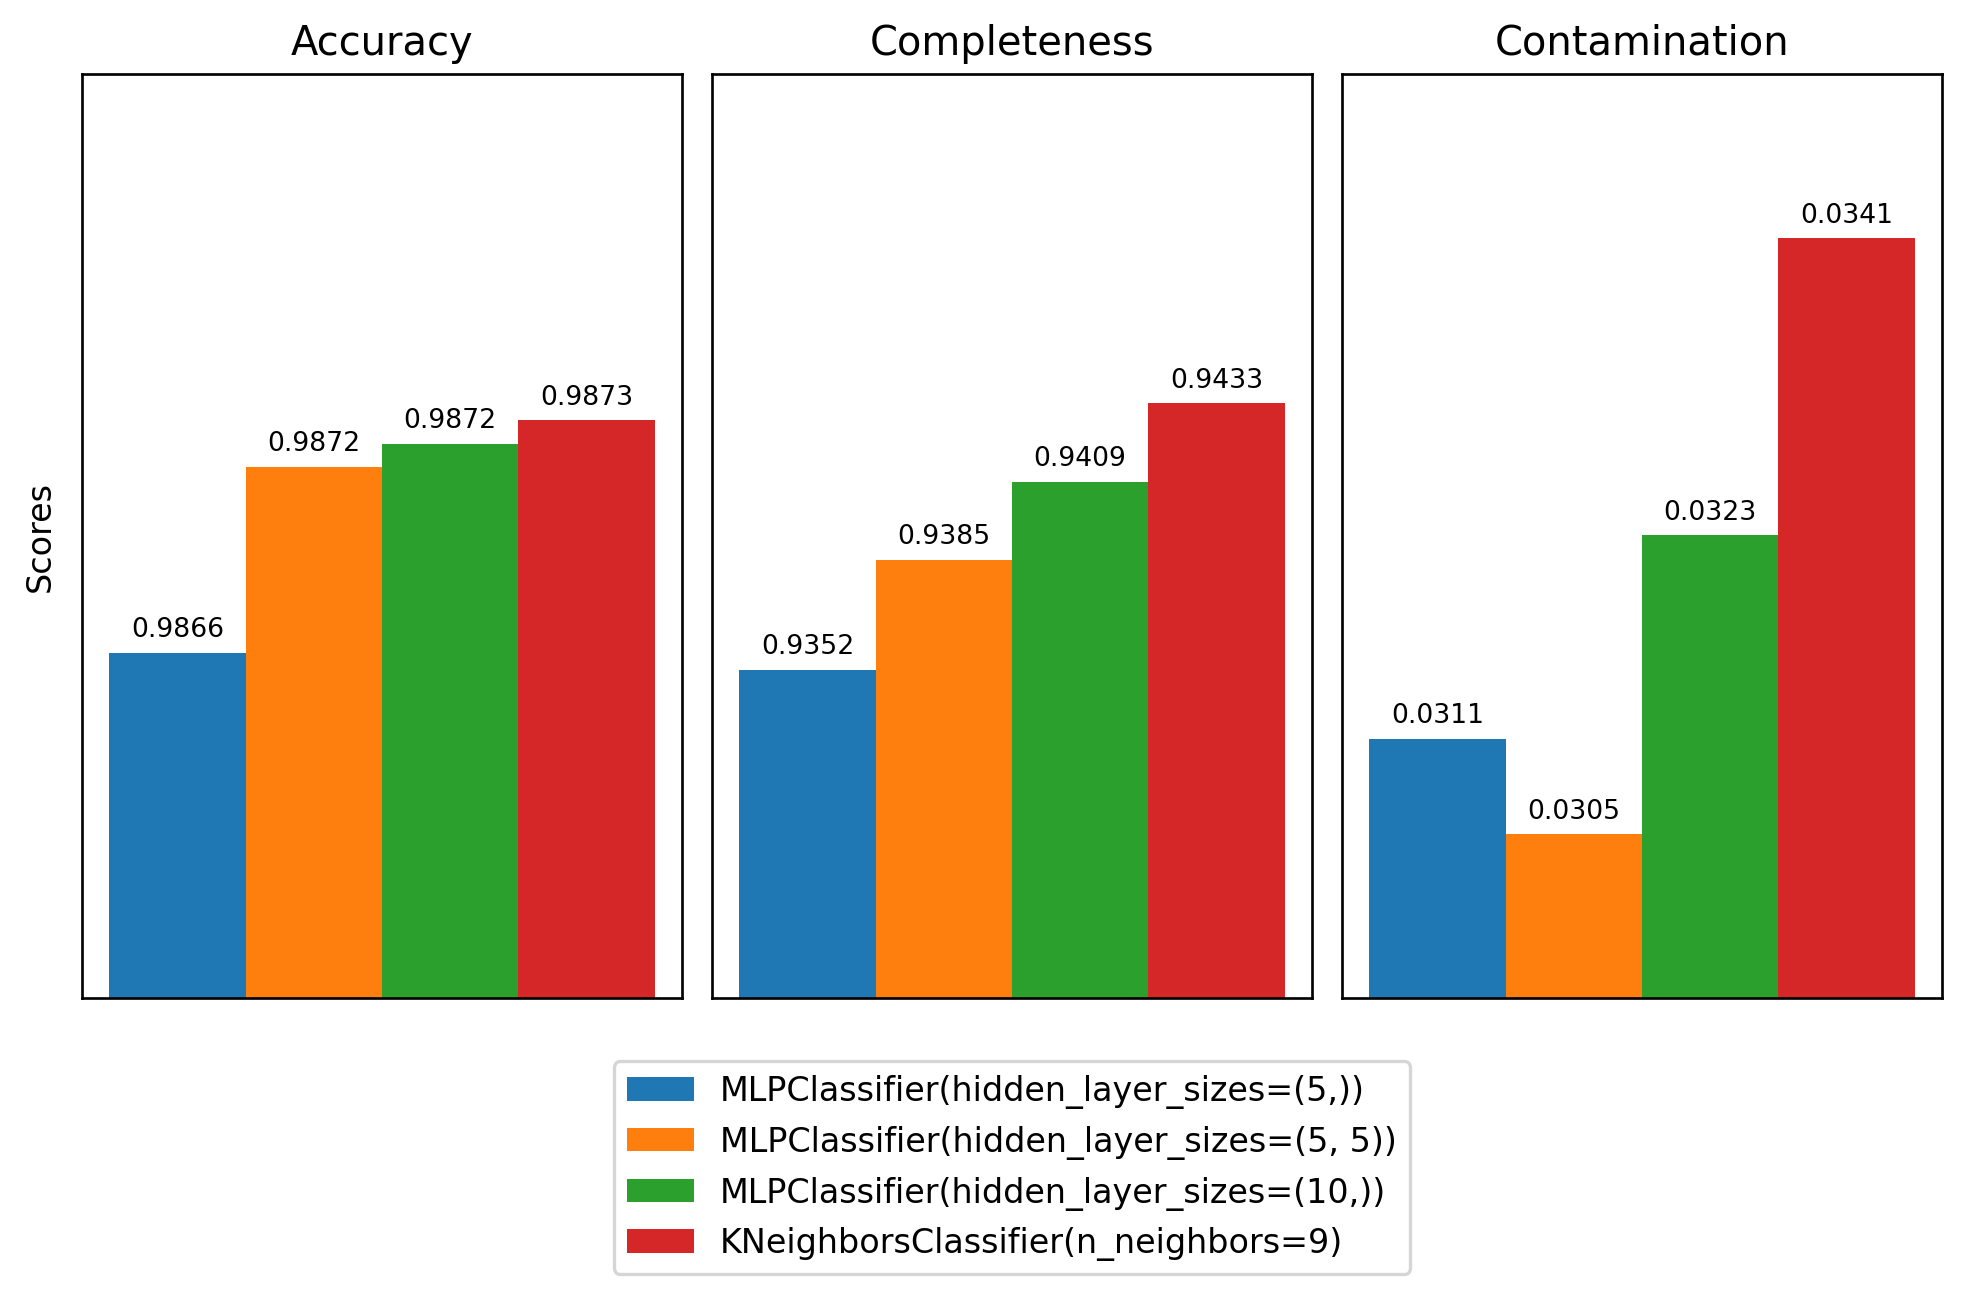

In [63]:
# Change colormap

# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list1))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

a = compare_classifiers(info_list1 )

Base versions of MLP CLassifier have performances similar to the best classifiers of the previous notebooks. Now we try to tune hyperparameters to improve performance.

### Tuning Hyperparameters
First we try to see how varying different hyperparameters impacts the performance, then we use cross-validation to find the best combination.

#### Early stopping
Investigate effect of early stopping

In [68]:

mlp_base = MLPClassifier(
                    hidden_layer_sizes=(5,),
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate_init=0.001)

list = []
for val_frac in np.linspace(0.1,0.5,10):
    mlp_base_val = clone(mlp_base)
    mlp_base_val.set_params(early_stopping = True, validation_fraction = val_frac)
    list.append(mlp_base_val)
    
clf_list = [mlp_base, *list]

In [69]:
info_list2 = run_classifier_list(clf_list)

,name,accuracy,completeness,contamination
0,"MLPClassifier(hidden_layer_sizes=(5,))",0.987173,0.939495,0.031434
7,"MLPClassifier(early_stopping=True, hidden_laye...",0.986501,0.933302,0.030198
8,"MLPClassifier(early_stopping=True, hidden_laye...",0.986367,0.934731,0.032544
4,"MLPClassifier(early_stopping=True, hidden_laye...",0.985964,0.930443,0.031250
10,"MLPClassifier(early_stopping=True, hidden_laye...",0.985695,0.933302,0.035925
1,"MLPClassifier(early_stopping=True, hidden_laye...",0.985494,0.928061,0.032290
5,"MLPClassifier(early_stopping=True, hidden_laye...",0.985494,0.931872,0.035978
3,"MLPClassifier(early_stopping=True, hidden_laye...",0.985292,0.930443,0.036032
9,"MLPClassifier(early_stopping=True, hidden_laye...",0.985292,0.933302,0.038763
2,"MLPClassifier(early_stopping=True, hidden_laye...",0.985158,0.928061,0.034688


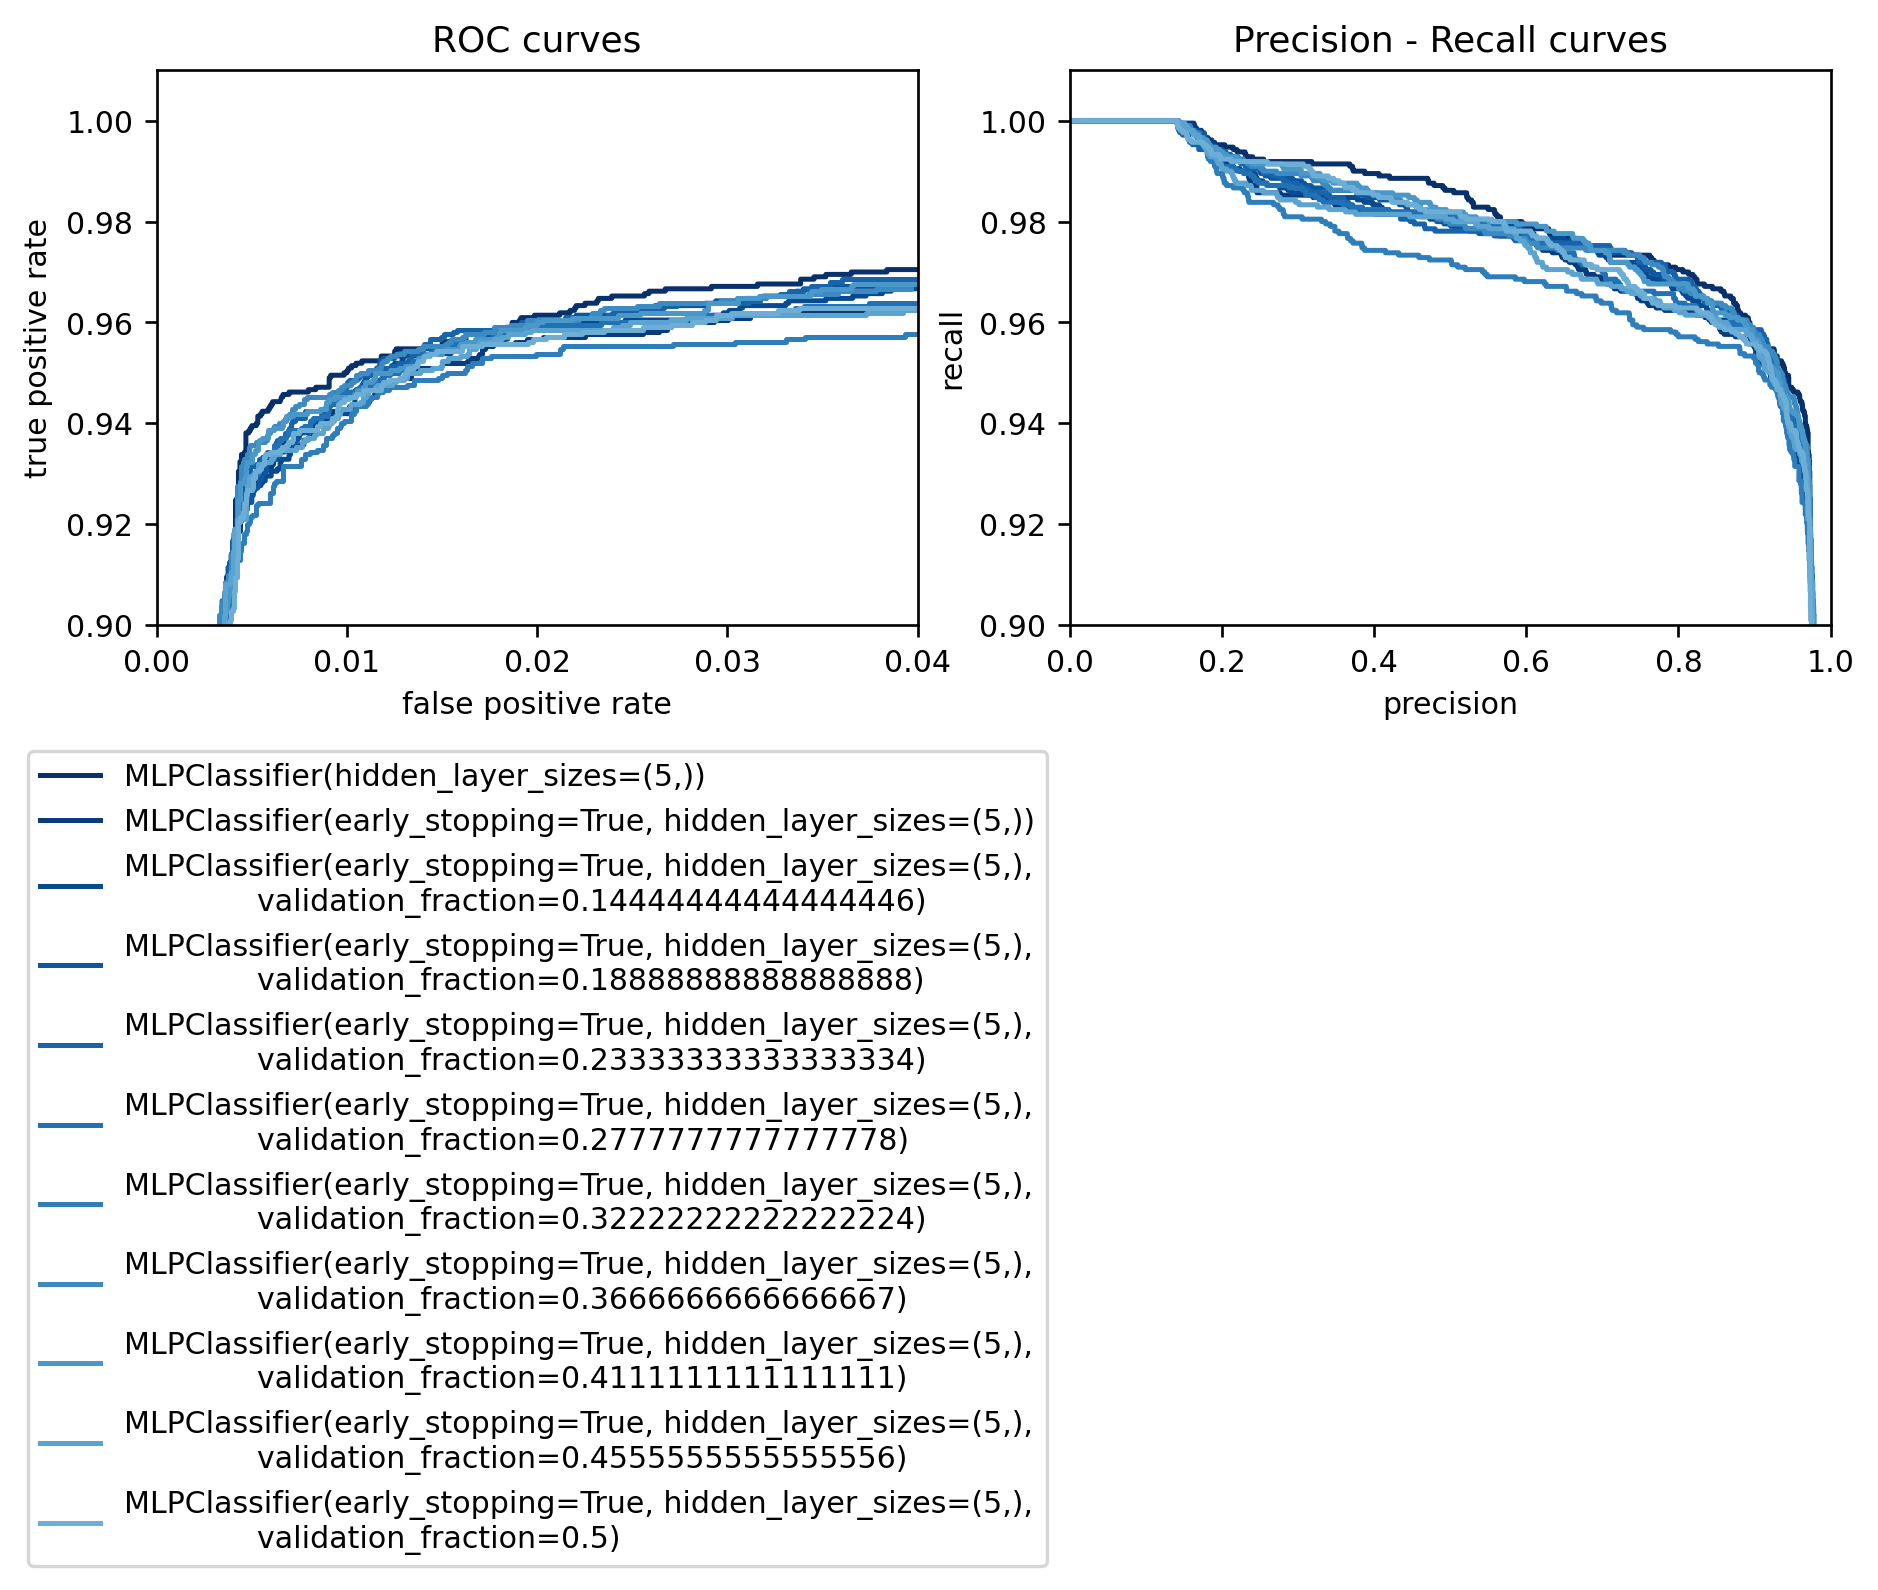

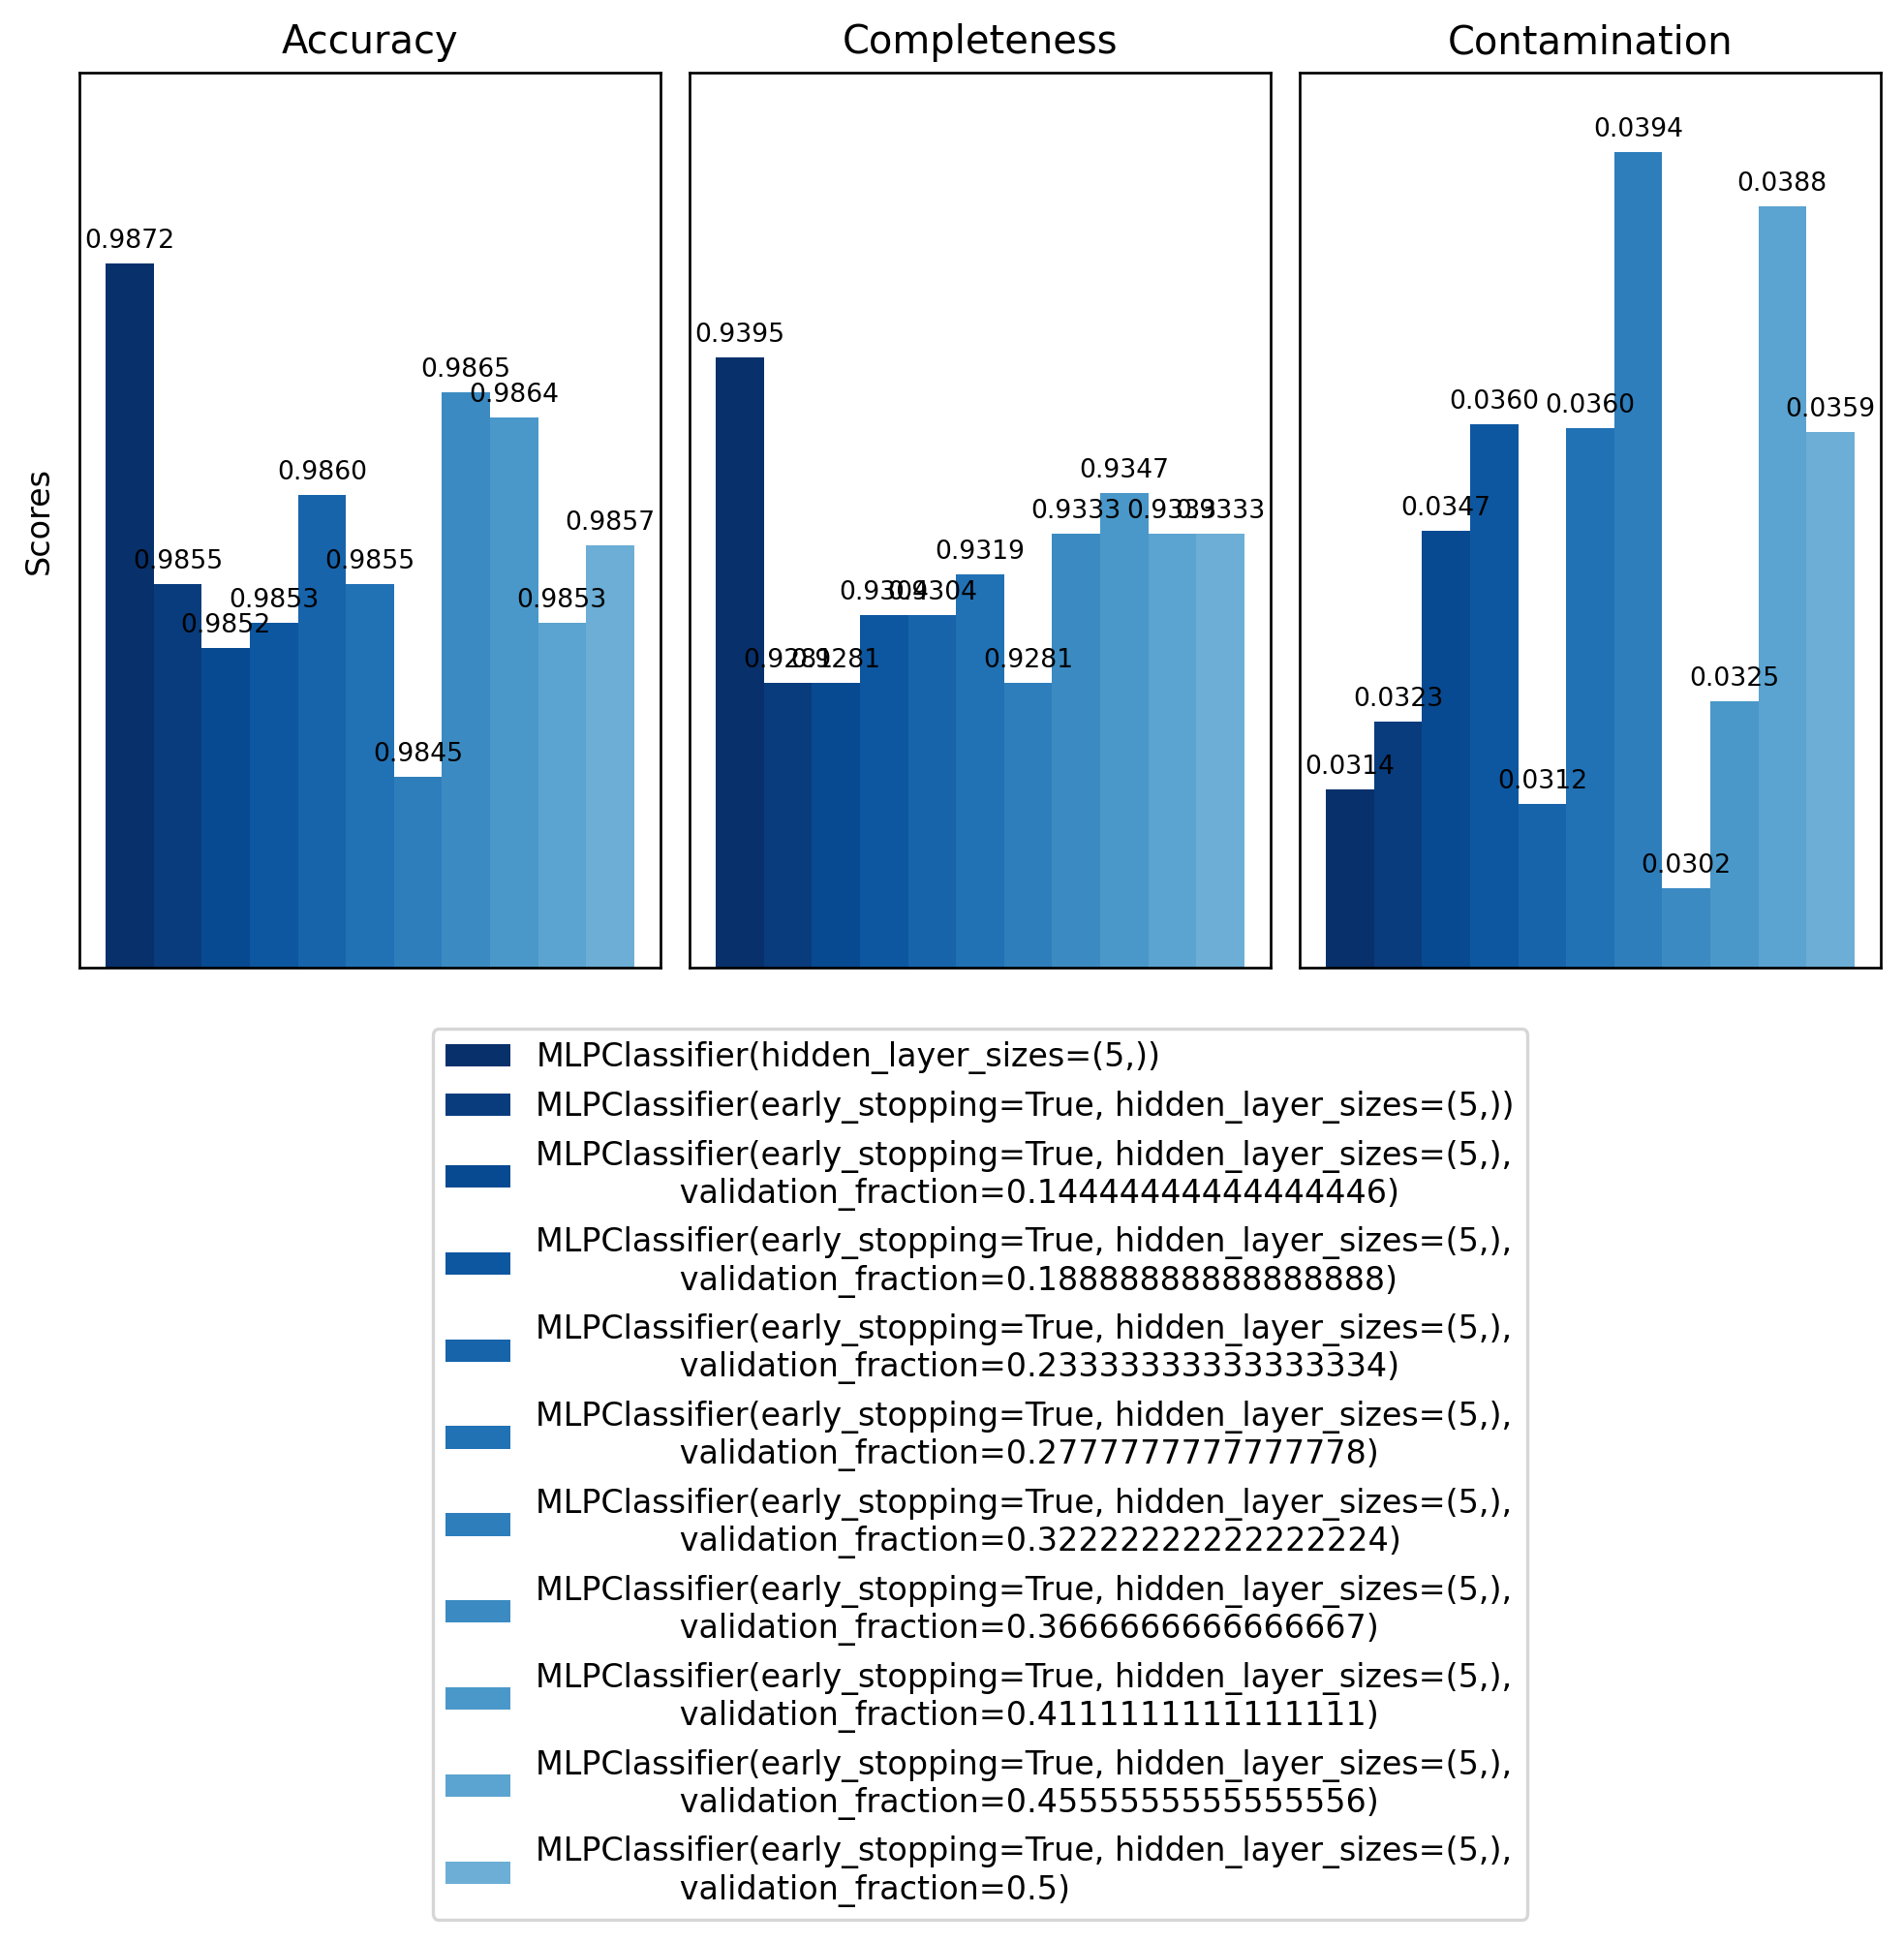

In [70]:

# ---------------Change colormap ----------------------------------------
cmap=plt.cm.Blues_r
c = cycler('color', cmap(np.linspace(0,0.5,len(info_list2))) )
plt.rcParams["axes.prop_cycle"] = c

# cmap=plt.cm.tab10
# c = cycler('color', cmap(range(10)))
# plt.rcParams["axes.prop_cycle"] = c
#------------------------------------------------------------------------------------

a2 = compare_classifiers(info_list2)


No improvement with early stopping on base MLP Classifier